In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("dataset3.csv")

In [3]:
df.head(20)

,number,week_day_hour,count
0,1,"0w, 0d, 0h",79
1,2,"0w, 0d, 10h",848
2,3,"0w, 0d, 11h",896
3,4,"0w, 0d, 12h",948
4,5,"0w, 0d, 13h",938
5,6,"0w, 0d, 14h",965
6,7,"0w, 0d, 15h",954
7,8,"0w, 0d, 16h",890
8,9,"0w, 0d, 17h",686
9,10,"0w, 0d, 18h",493


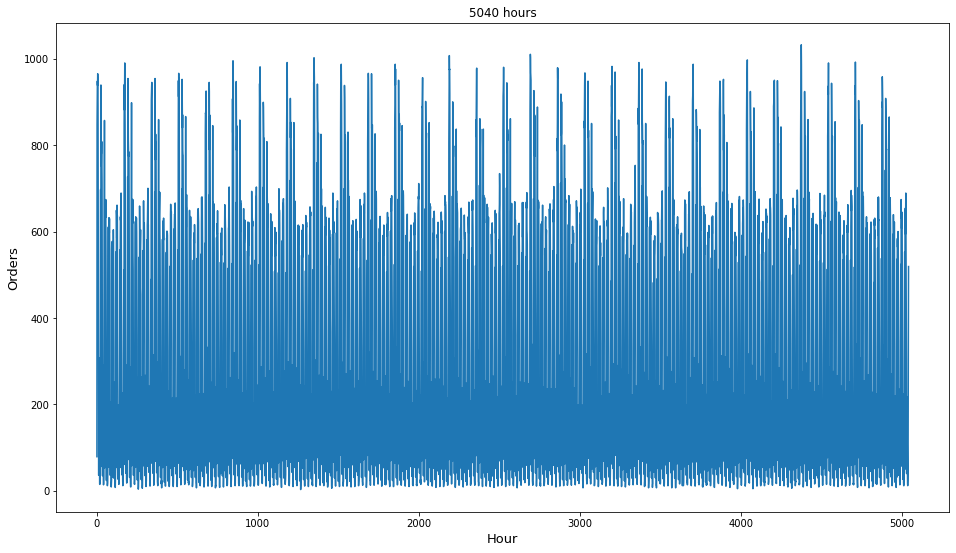

In [34]:
plt.plot(df['number'].values, df['count'].values)
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Hour', fontsize=13)
plt.ylabel('Orders', fontsize=13)
plt.title('5040 hours')
plt.show()

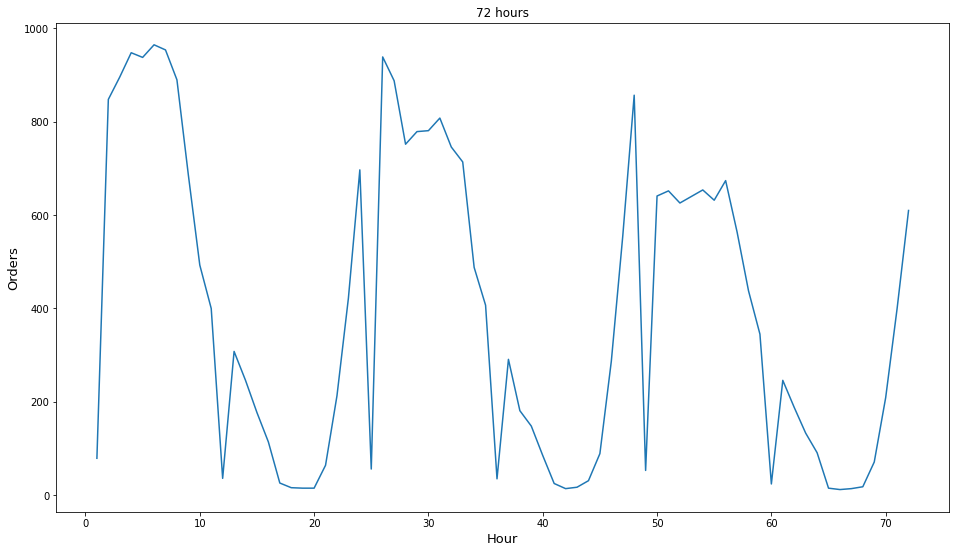

In [5]:
hours = 72
plt.plot(df.head(hours)['number'].values, df.head(hours)['count'].values)
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Hour', fontsize=13)
plt.ylabel('Orders', fontsize=13)
plt.title(f'{hours} hours')
plt.show()

In [6]:
# kfold = 2
# itog_val = {}
# X = df["count"]
# y = df["number"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# print ('обучающая выборка:\n', X_train[:9])
# print ('\n')
# print ('тестовая выборка:\n', X_test[:7])
# X_train.shape

In [8]:
# clf = AdaBoostClassifier() 
# scores = cross_val_score(clf, X_train, y_train, cv=540)
# itog_val['AdaBoostClassifier'] = scores.mean()
# print ('итог', itog_val)

In [9]:
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
# y_test_predicted = clf.predict(X_test)
# print ('AdaBoostClassifier first 9 predicted values:\n', y_test_predicted[:9])

In [10]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [11]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = df['count'].values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    
    result = np.mean(np.array(errors))
    
    # print("-> ", result)
    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return result

In [12]:
# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.059075701373325906 0.0 0.0


In [13]:
# Передаем оптимальные значения модели, 
model = HoltWinters(df['count'][:-168], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 168, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [95]:
data = df['count']

def plotHoltWinters(last_items = False):
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(45, 25))
    plt.plot(model.result, label = "Model")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.axvspan(len(data)-168, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13, prop={'size': 50});
    if last_items: plt.xlim([4704, 5040])
    plt.xlabel('Hour', fontsize=50)
    plt.ylabel('Orders', fontsize=50)
    plt.title('Orders per hour',fontsize=70)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)

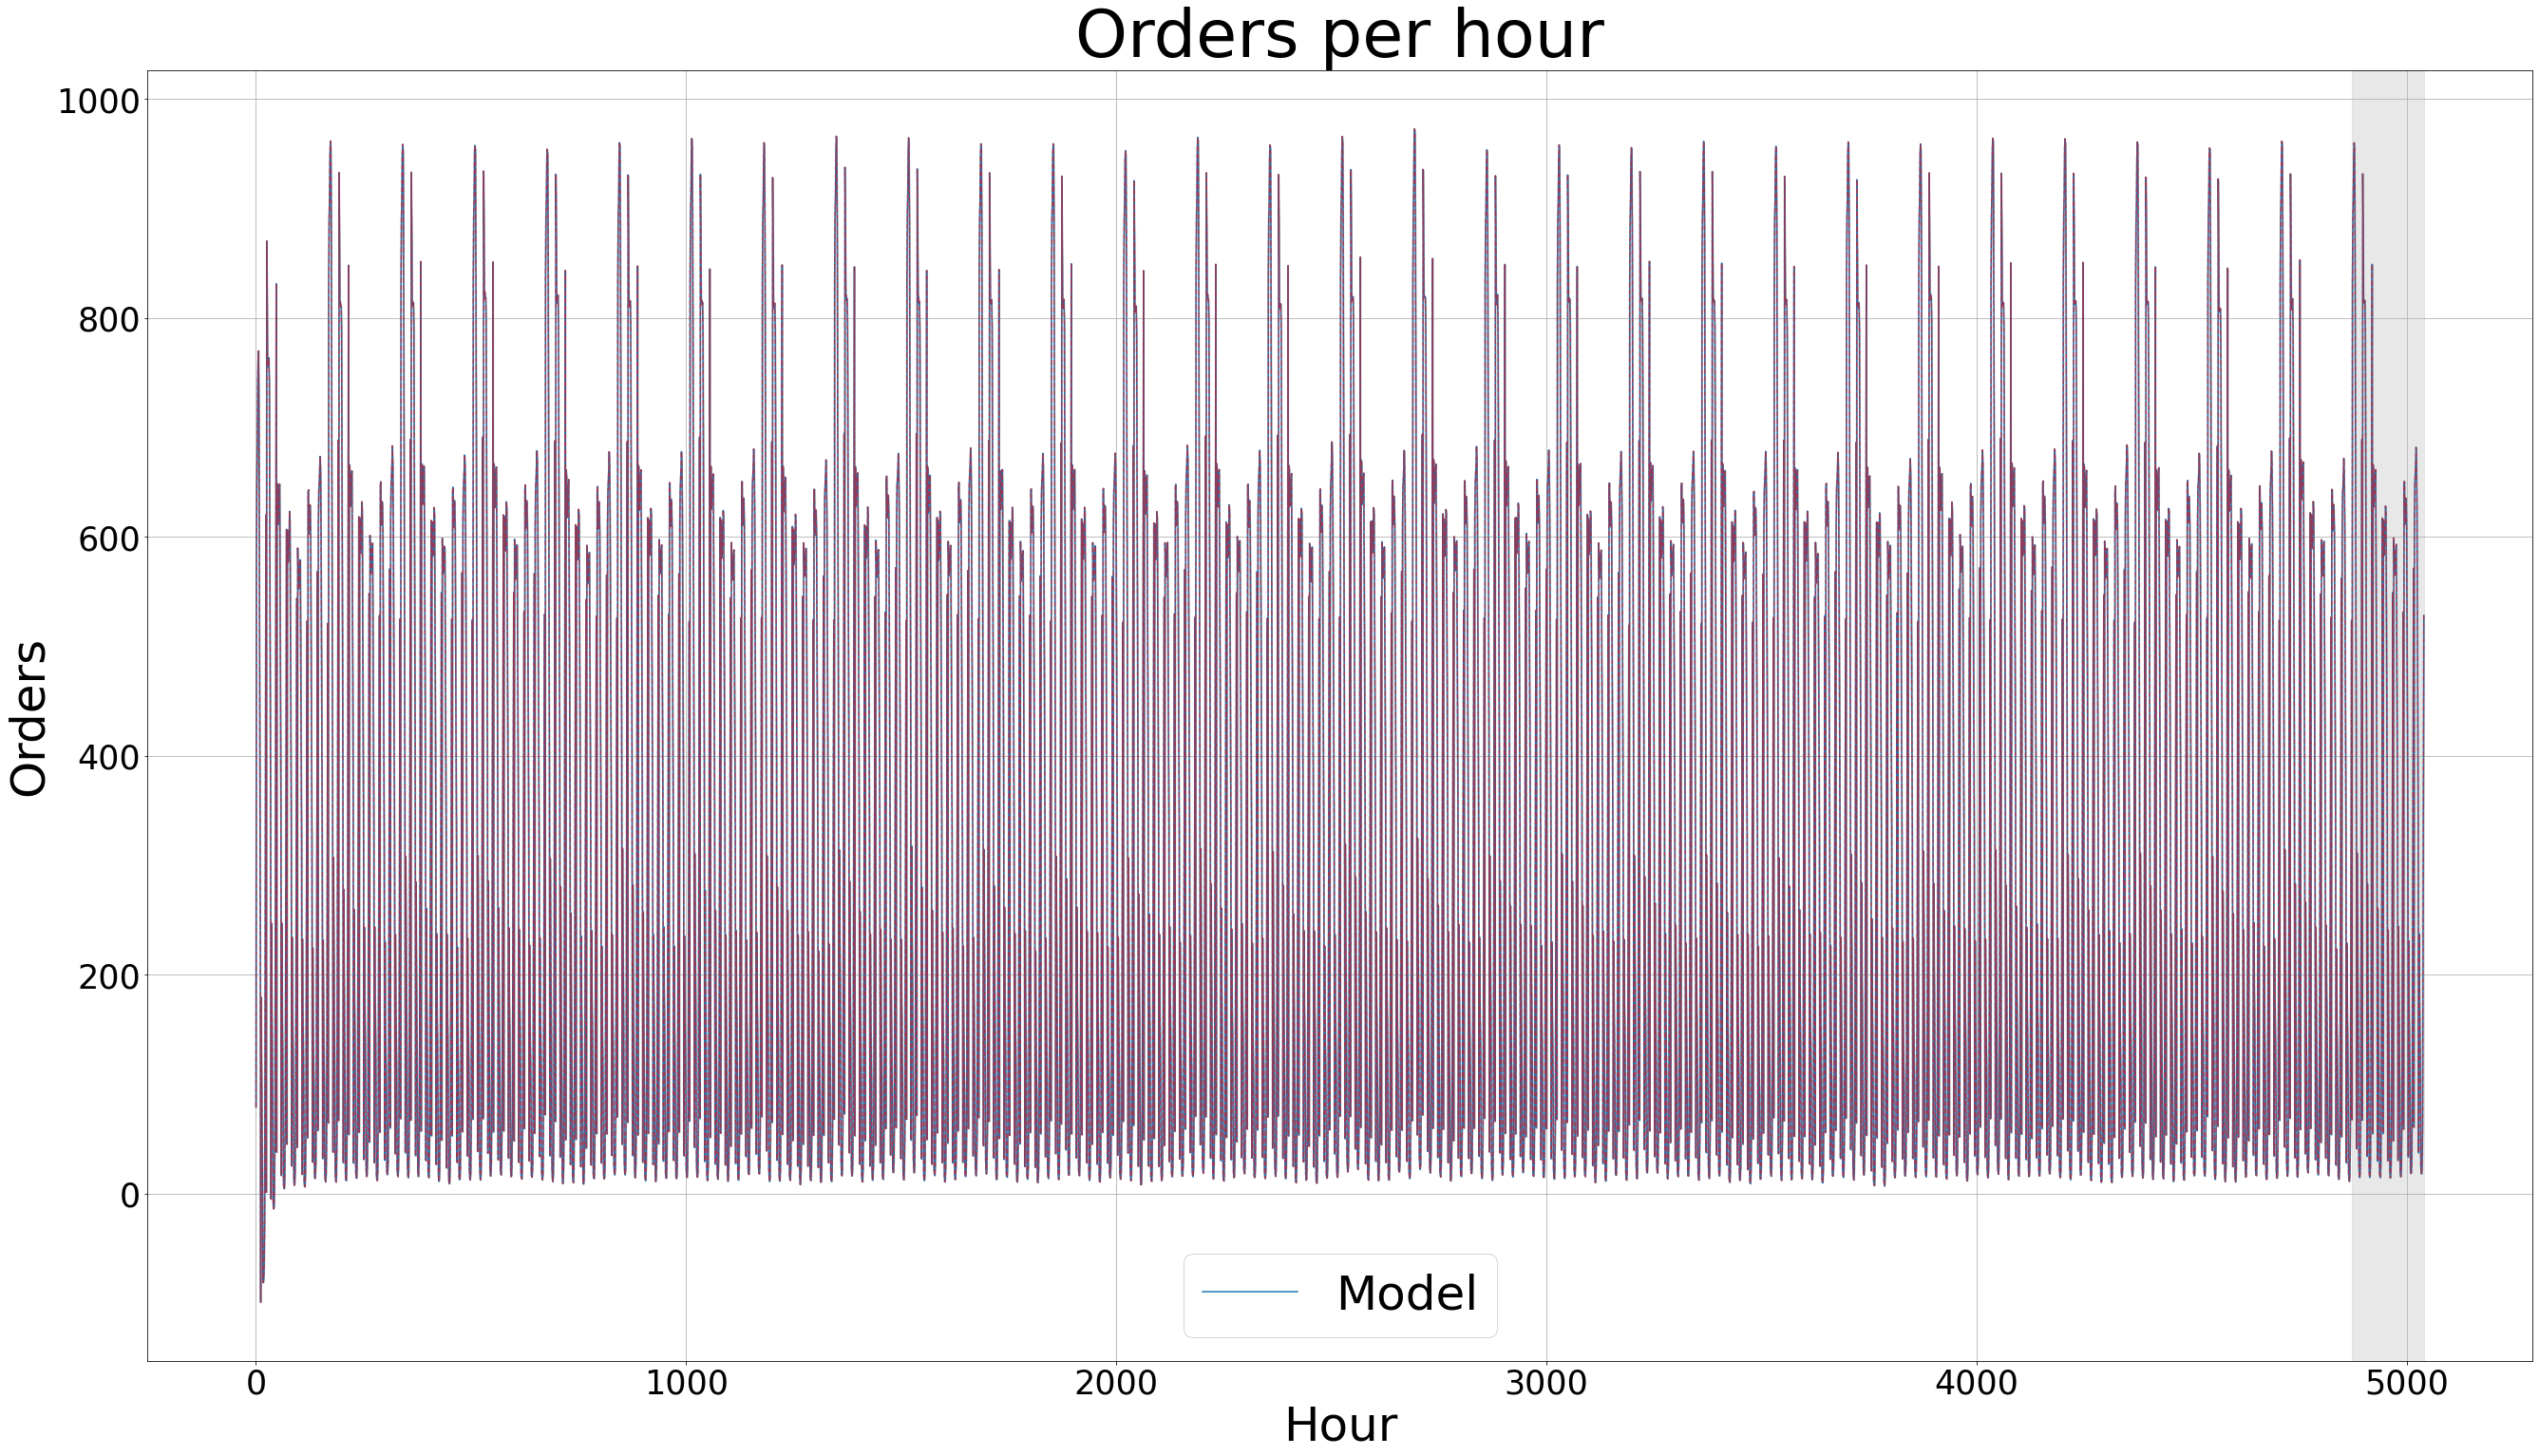

In [96]:
plotHoltWinters()

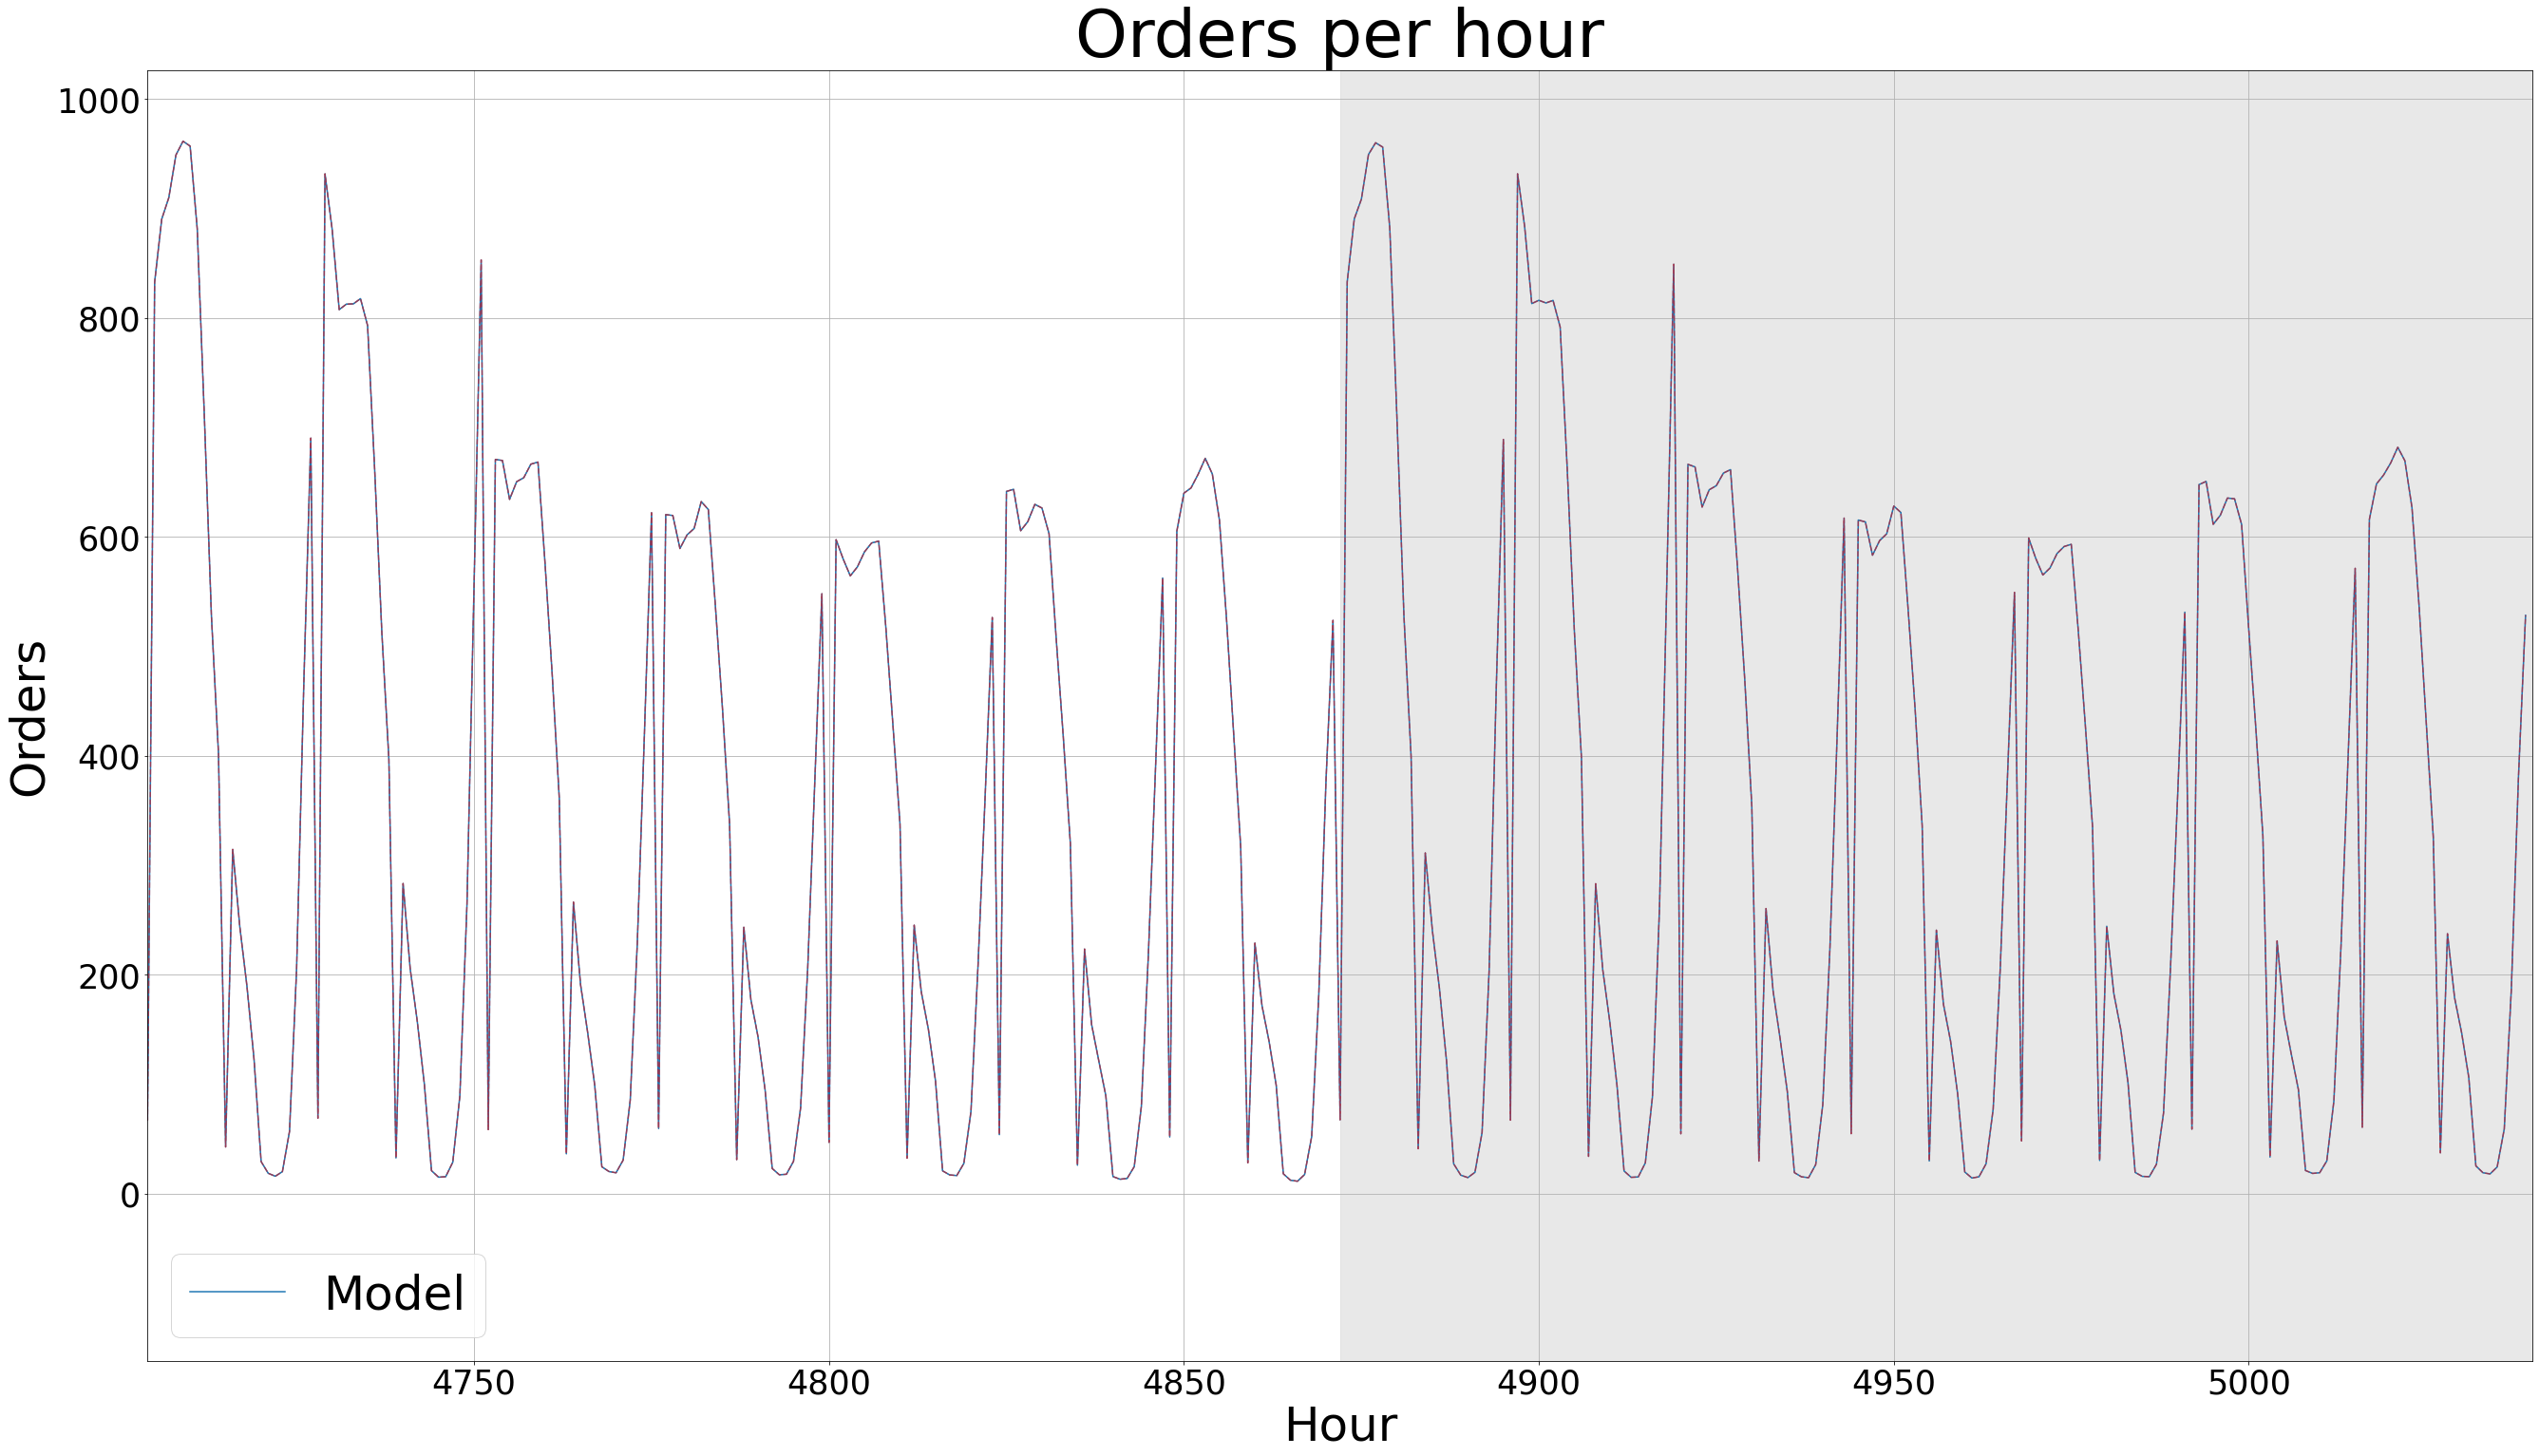

In [97]:
plotHoltWinters(last_items=True)